# Linear bandits

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import random

## Environment

In [2]:
class ResultLB:
    def __init__(self, horizon):
        self.rewards = np.zeros(horizon)

    def store(self, t, reward):
        self.rewards[t] = reward

In [3]:
class LB:
    def __init__(self, theta, sigma_2=1):
        self.theta = theta
        self.sigma_2 = sigma_2

    def play(self, algo, horizon):
        result = ResultLB(horizon)
        algo.start_game()
        for t in range(horizon):
            choice = algo.choice()
            expected_reward = np.dot(choice, self.theta)
            reward = expected_reward + random.gauss(0, np.sqrt(self.sigma_2))
            algo.get_reward(reward)
            result.store(t, expected_reward)
    
        return result 

In [4]:
def oracle(x, theta):
    return - np.dot(x, theta)


class EvaluationBayesLB:
    def __init__(self, envs, algo, horizon, tsav=[]):
        if len(tsav) > 0:
            self.tsav = tsav
        else:
            self.tsav = np.arange(horizon)
        
        self.nb_repetitions = len(envs)
        self.cum_reward = np.zeros((self.nb_repetitions, len(self.tsav)))
        self.oracle = np.zeros((self.nb_repetitions, len(self.tsav)))

        for k in range(self.nb_repetitions):
            if self.nb_repetitions < 10 or k % (self.nb_repetitions / 10) == 0:
                print(k)
                
            result = envs[k].play(algo, horizon)
            self.cum_reward[k, :] = np.cumsum(result.rewards)[self.tsav]
            
            d = len(envs[k].theta)
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.linalg.norm(x)})
            bnds = [(-1,1)] * d
            
            res = minimize(oracle, 
                           2 / np.sqrt(d) * np.random.rand(d) - 1 / np.sqrt(d),
                           args=envs[k].theta,
                           bounds=bnds, 
                           constraints=cons)
        
            self.oracle[k, :] = (1 + self.tsav) * (-res.fun)
        
    def std_regret(self):
        return np.std(self.oracle - self.cum_reward, 0)

    def mean_regret(self):
        return np.mean(self.oracle, 0) - np.mean(self.cum_reward, 0)

## Algorithms

In [5]:
class LinUCB:
    """
        Ref: Improved algorithms for linear stochastic bandits. Abbasi-Yadkori, Y., Pál, D., & Szepesvári, C. (2011). 
    """
    
    def __init__(self, d, delta, lambd, m_2=1, L=1):
        self.delta = delta
        self.lambd = lambd
        self.d = d
        self.m_2 = m_2
        self.L = L

    def start_game(self):
        self.t = 1
        self.rewards = []
        self.chosen_arms = []

    def objective(self, x):
        a = x[:self.d]
        theta = x[self.d:]
        return - np.dot(a, theta)
        
    def choice(self):
        if self.t == 1:
            choice = 2 * np.random.rand(self.d) - 1
            choice = choice / np.linalg.norm(choice)
            self.chosen_arms += [choice]
            return choice
        
        ## Compute theta
        V = self.lambd * np.eye(self.d)
        theta = np.zeros(self.d)
        for s in range(self.t-1):
            a = self.chosen_arms[s][np.newaxis]
            V += np.dot(a.T, a)
            theta += self.chosen_arms[s] * self.rewards[s]
        inv_V = np.linalg.inv(V)
        theta = np.dot(inv_V, theta)
        
        ## Compute sqrt_beta
        sqrt_beta = (np.sqrt(self.lambd) * self.m_2 + 
                     np.sqrt(2 * np.log(1 / self.delta) + 
                             self.d * np.log((self.d * self.lambd + self.t * self.L**2) / (self.d * self.lambd))))
        
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.linalg.norm(x[:self.d])},
                {'type': 'ineq', 'fun': lambda x: sqrt_beta**2 - 
                 ((x[self.d:]-theta)[np.newaxis] @ V @ (x[self.d:]-theta)[np.newaxis].T)[0, 0]})
        bnds = [(-1,1)] * self.d + [(-5, 5)] * self.d
        a0 = 2 * np.random.rand(self.d) - 1
        a0 = a0 / np.linalg.norm(a0)
        x0 = np.concatenate((a0, theta))
        
        res = minimize(self.objective, x0, bounds=bnds, constraints=cons, tol=1e-2)
        choice = res.x[:self.d]
        
        if not res.success:
            #print('Error', self.t)
            choice = 2 * np.random.rand(self.d) - 1
            choice = choice / np.linalg.norm(choice)
        self.chosen_arms += [choice]
        return choice
        
    def get_reward(self, reward):
        self.rewards += [reward]
        self.t += 1

In [6]:
class BallExplore:
    """
        Ref: Linear bandits in high dimension and recommendation systems. Deshpande, Y., & Montanari, A. (2012).
    """
    
    def __init__(self, d, sigma_2=1, delta=0):
        self.d = d
        self.sigma_2 = sigma_2
        if delta == 0:
            self.delta = d
        else:
            self.delta = delta

    def start_game(self):
        self.t = 1
        self.theta = np.zeros(self.d)
        self.sigma = np.eye(self.d) / self.d
        temp = np.zeros(self.d)
        temp[0] = 1
        self.P = np.eye(self.d) - temp[np.newaxis].T @ temp[np.newaxis]
        
        self.rewards = []
        self.chosen_arms = []

    def choice(self):
        if self.t == 1:
            x_tilda = np.zeros(self.d)
            x_tilda[0] = 1
        else:
            x_tilda = self.theta / np.linalg.norm(self.theta)
        
        beta = np.sqrt(2/3) * min(self.d * self.delta / self.t, 1)**(1/4)
        
        u = np.random.rand(self.d)
        u /= np.linalg.norm(u)
    
        choice = np.sqrt(1 - beta**2) * x_tilda + beta * self.P @ u
        
        self.chosen_arms += [choice]
        return choice
        
    def get_reward(self, reward):
        self.rewards += [reward]
        self.t += 1
        
        # Update theta
        bnds = [(-1,1)] * self.d
        res = minimize(self.objective, self.theta, bounds=bnds, tol=1e-4)
        self.theta = res.x
        
        # Update P
        self.P = np.eye(self.d) - self.theta[np.newaxis].T @ self.theta[np.newaxis] / (np.linalg.norm(theta)**2)
        
    def objective(self, theta):
        temp = 0
        for s in range(self.t-1):
            temp += (self.rewards[s] - np.dot(self.chosen_arms[s], theta))**2
        return temp / (2 * self.sigma_2) + np.linalg.norm(theta)**2 / (2 * self.d)

In [7]:
class LinGreedy:
    def __init__(self, d, lambd=0):
        self.lambd = lambd
        self.d = d

    def start_game(self):
        self.t = 1
        self.rewards = []
        self.chosen_arms = []

    def objective(self, x, theta):
        return - np.dot(x, theta)
        
    def choice(self):
        if self.t == 1:
            choice = 2 * np.random.rand(self.d) - 1
            choice = choice / np.linalg.norm(choice)
            self.chosen_arms += [choice]
            return choice
        
        ## Compute theta
        V = self.lambd * np.eye(self.d)
        theta = np.zeros(self.d)
        for s in range(self.t-1):
            a = self.chosen_arms[s][np.newaxis]
            V += np.dot(a.T, a)
            theta += self.chosen_arms[s] * self.rewards[s]
        inv_V = np.linalg.pinv(V)
        theta = np.dot(inv_V, theta)
        
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.linalg.norm(x[:self.d])})
        bnds = [(-1,1)] * (self.d)
        a0 = 2 * np.random.rand(self.d) -1
        a0 = a0 / np.linalg.norm(a0)
        res = minimize(self.objective, a0, args=(theta), bounds=bnds, constraints=cons, tol=1e-4)
        #res = minimize(self.objective, a0, args=(theta), bounds=bnds, constraints=cons)
        choice = res.x
        
        if not res.success:
            #print('Error', self.t)
            choice = 2 * np.random.rand(self.d) - 1
            choice = choice / np.linalg.norm(choice)
        self.chosen_arms += [choice]
        return choice
        
    def get_reward(self, reward):
        self.rewards += [reward]
        self.t += 1

## Experimental setup

In [8]:
scenario = 0
nb_rep = 10

In [9]:
np.random.seed(1234)

if scenario == 0:
    horizon = 2500
    d = 50
    noise = 1
    envs = []
    for _ in range(nb_rep):
        theta = 2 * np.random.rand(d) - 1
        theta = theta / np.linalg.norm(theta)
        envs += [LB(theta, noise)]

## Compare various algorithms

In [10]:
algorithms = [LinUCB(d, 1/horizon, 1), 
              LinGreedy(d, lambd=1),
              BallExplore(d)]

Start evaluation of LinUCB
0
1
2
3
4
5
6
7
8
9
Regret of LinUCB : 2038.3204013293428 +- 62.870923898144504 obtained in 15076.667483568192 seconds 

Start evaluation of LinGreedy
0
1
2
3
4
5
6
7
8
9
Regret of LinGreedy : 1774.6994098762025 +- 149.49140247226583 obtained in 1331.7040519714355 seconds 

Start evaluation of BallExplore
0
1
2
3
4
5
6
7
8
9
Regret of BallExplore : 1847.261423736526 +- 207.36551433934918 obtained in 61609.31638932228 seconds 



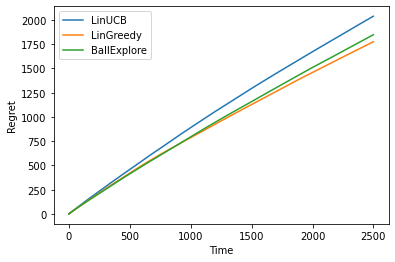

In [11]:
plt.figure()

for algo in algorithms:
    print('Start evaluation of', algo.__class__.__name__)
    start_time = time.time()
    ev = EvaluationBayesLB(envs, algo, horizon)
    mean_regret = ev.mean_regret()
    std_regret = ev.std_regret()
    print('Regret of', algo.__class__.__name__, ':', mean_regret[-1], '+-', std_regret[-1], 
          'obtained in', time.time() - start_time, 'seconds \n')
    
    plt.plot(np.arange(horizon), mean_regret)
    #plt.fill_between(np.arange(horizon), mean_regret-std_regret, mean_regret+std_regret, alpha=.2)
    plt.xlabel('Time')
    plt.ylabel('Regret')

plt.legend([algo.__class__.__name__ for algo in algorithms], loc=0)
plt.show()